In [1]:
import numpy as np
import matplotlib.pyplot as plt
import transformers
import os
import random
import h5py
import pandas as pd
import time
import importlib
from pprint import pprint
import torch 
from tqdm import tqdm
from src.qwen import load_qwen
import re
import yaml
import json
import gc
from torch.utils.data import TensorDataset, DataLoader
import transformers
from transformers import AutoModelForCausalLM

/home/am3353/am3353/m2-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu' 
print('Device-activated: ', device)

file_path = "data/lotka_volterra_data.h5"  # Change this to the correct path  Out [9]:  Device-activated:  cpu
final_model_config_path = 'saves/hyper/hyperparameter_results.json'
final_model_path = 'saves/final_model.pt'

Device-activated:  cpu


In [3]:
!lscpu

Architecture:        x86_64
CPU op-mode(s):      32-bit, 64-bit
Byte Order:          Little Endian
CPU(s):              76
On-line CPU(s) list: 0-75
Thread(s) per core:  1
Core(s) per socket:  38
Socket(s):           2
NUMA node(s):        2
Vendor ID:           GenuineIntel
CPU family:          6
Model:               106
Model name:          Intel(R) Xeon(R) Platinum 8368Q CPU @ 2.60GHz
Stepping:            6
CPU MHz:             997.319
CPU max MHz:         3700.0000
CPU min MHz:         800.0000
BogoMIPS:            5200.00
L1d cache:           48K
L1i cache:           32K
L2 cache:            1280K
L3 cache:            58368K
NUMA node0 CPU(s):   0,2,4,6,8,10,12,14,16,18,20,22,24,26,28,30,32,34,36,38,40,42,44,46,48,50,52,54,56,58,60,62,64,66,68,70,72,74
NUMA node1 CPU(s):   1,3,5,7,9,11,13,15,17,19,21,23,25,27,29,31,33,35,37,39,41,43,45,47,49,51,53,55,57,59,61,63,65,67,69,71,73,75
Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush d

In [4]:
import src
import src.data_prepare_ntbk
import src.forecast 
import src.preprocess
import src.lora 
import src.data_create

importlib.reload(src)
importlib.reload(src.forecast)
importlib.reload(src.preprocess)
importlib.reload(src.lora)
importlib.reload(src.data_create)
importlib.reload(src.data_prepare_ntbk)

from src.forecast import *
from src.lora import LoRALinear
from src.preprocess import *
from src.data_create import *
from src.data_prepare_ntbk import *  

In [5]:
random_state = 28
np.random.seed(random_state)     

In [6]:
ft = time.time()
_, tokenizer = load_qwen()
lt = time.time()

print('time-taken: ', (lt - ft)/60, 'mins') 

# pprint(model_lora.config)

Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


time-taken:  0.037257870038350425 mins


Can directly load modified model --> LoRATrainer.get_model()

In [7]:
def load_config(config_path):
    with open(config_path, "r") as file:
        config = yaml.safe_load(file)
    return config

In [8]:
manual_config = load_config("src/config.yaml")  

train_split = manual_config['train_split']
time_step_split = manual_config['time_step_split']
batch_size = manual_config['batch_size']
learning_rate = manual_config['learning_rate'] # 1e-5
lora_rank = manual_config['lora_rank']
max_ctx_length = manual_config['seq_length']
forecast_length = manual_config['forecast_length']
max_tokens = manual_config['seq_length']  

##### Final Model Config

In [9]:
with open(final_model_config_path, 'r') as file:
        best_config = json.load(file)
file.close()

best_config = best_config[1]
lora_rank = best_config['lora_rank']
max_ctx_length = best_config['context_length']
max_tokens = best_config['context_length']

print('lora-rank: ', lora_rank, ', context-length: ', max_ctx_length, ', max-tokens: ', max_tokens)

lora-rank:  8 , context-length:  768 , max-tokens:  768


In [10]:
# model_lora.config.max_position_embeddings = max_ctx_length

In [11]:
data_prey, data_prey_true, data_pred, data_pred_true, time_data_past, time_data_true = load_data(file_path, time_step_split, is_plot = True)
print(data_prey.shape, data_prey_true.shape, data_pred.shape, data_pred_true.shape, time_data_past.shape, time_data_true.shape)

check_rn = random.randint(0, len(data_prey))
print('check_rn: ', check_rn)

Keys in HDF5 file: ['time', 'trajectories']
(1000, 80) (1000, 21) (1000, 80) (1000, 21) (80,) (21,)
check_rn:  760


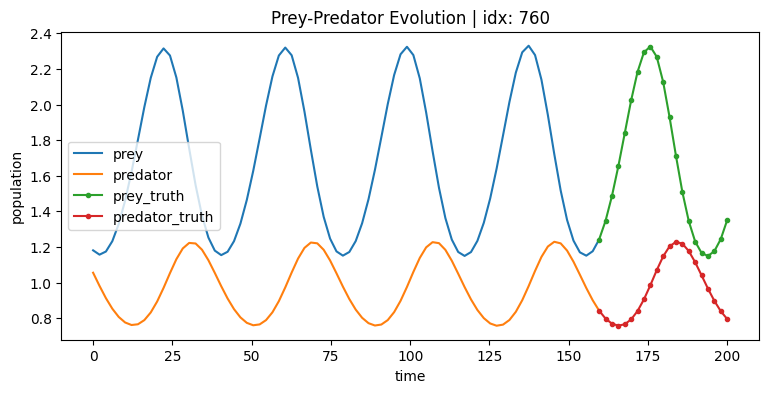

In [12]:
fig = plt.figure(figsize=(9, 4))

plt.plot(time_data_past, data_prey[check_rn], label = 'prey')
plt.plot(time_data_past, data_pred[check_rn], label = 'predator')

plt.plot(time_data_true, data_prey_true[check_rn], label = 'prey_truth', marker = '.')
plt.plot(time_data_true, data_pred_true[check_rn], label = 'predator_truth', marker = '.')

plt.xlabel('time')
plt.ylabel('population')

plt.legend()
plt.title(f'Prey-Predator Evolution | idx: {check_rn}')
plt.show()  

In [13]:
train_input_ids, val_input_ids, prey_os, pred_os, test_encoded = prepare_data(data_prey, data_pred, tokenizer, max_ctx_length, train_split, forecast_length=forecast_length, is_forecast=True)
print(train_input_ids.shape, val_input_ids.shape, test_encoded.shape)

torch.Size([900, 768]) torch.Size([100, 768]) (100,)


In [14]:
train_dataset = TensorDataset(train_input_ids)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(val_input_ids)
val_loader = DataLoader(val_dataset, batch_size=batch_size)  

In [15]:
for batch_t, batch_v in zip(train_loader, val_loader):
    print(batch_t[0].shape, batch_v[0].shape)
    break

torch.Size([4, 768]) torch.Size([4, 768])


##### LoRA - Change (For Verification)

In [ ]:
# ### replacing attention layers with trainable layers (r * in_dim) + (out_dim * r)
# for layer in model_lora.model.layers:
#     layer.self_attn.q_proj = LoRALinear(layer.self_attn.q_proj, r=lora_rank) 
#     layer.self_attn.v_proj = LoRALinear(layer.self_attn.v_proj, r=lora_rank)  

In [ ]:
# def get_model_params(model):
#         total_params = sum(p.numel() for p in model.parameters())
#         trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
#         return total_params, trainable_params

# total, trainable = get_model_params(model_lora)
# print(f"Total Parameters: {total:,}")
# print(f"Trainable Parameters: {trainable:,}") ## 100x lesser

Total Parameters: 494,725,376
Trainable Parameters: 692,608


In [ ]:
# optimizer = torch.optim.Adam((p for p in model_lora.parameters() if p.requires_grad), lr=learning_rate)

In [ ]:
# # accelerator = Accelerator()
# # model_lora, optimizer, train_loader, val_loader = accelerator.prepare(model_lora, optimizer, train_loader, val_loader)

# model_lora.train()

# target_steps = manual_config['training_steps']  # Optimization Steps
# print('Target-Train-Steps:', target_steps)

# train_steps = 0
# progress_bar = tqdm(range(target_steps), desc="Training Steps")

# train_curve, val_curve = [], []

# ft = time.time()

# while train_steps < target_steps:
#     for batch_input_ids, batch_target_ids in train_loader:
#         optimizer.zero_grad()
#         outputs = model_lora(batch_input_ids, labels=batch_target_ids)  # Use target_ids
#         loss = outputs.loss  # Loss function is a model attribute
#         loss.backward()
#         optimizer.step()

#         train_curve.append(loss.detach().cpu().item())  # Store loss for monitoring

#         train_steps += 1
#         progress_bar.update(1)
#         progress_bar.set_postfix(loss=loss.item())
        
#         ### FOR EVERY TRAINING-STEP WE RUN V-B BATCH 0(T_B * V_B)
#         # Validation Loop

#         model_lora.eval()
#         val_losses = []

#         with torch.no_grad():
#             for batch_input_ids, batch_target_ids in val_loader:
#                 val_op = model_lora(batch_input_ids, labels=batch_target_ids)
#                 val_losses.append(val_op.loss.cpu().item())
            
#             # Calculate average validation loss
#             avg_val_loss = sum(val_losses) / len(val_losses)
#             val_curve.append(avg_val_loss)
            
#         if train_steps >= target_steps:  # Stop training at the required steps
#             break
        
#         model_lora.train()  # Resume training mode
    
# lt = time.time()
# print('Time taken:', (lt - ft) / 60, 'mins')

# model_lora.eval()

In [ ]:
# plt.plot(range(len(train_curve)), train_curve, color = 'red', marker = '.', label = 'Train')
# plt.plot(range(len(val_curve)), val_curve, color = 'blue', marker = '.', label = 'Validation')

# plt.ylabel('Loss')
# plt.xlabel('#Optimization Steps')

# plt.title('Loss-Curve')

# plt.legend()
# plt.grid()
# plt.show()

#### Loading Saved Model (Direct Architechture + Weights Load)

In [16]:
# final_model_path = 'saves/best_final_model.pt' ### ran through final_model.py

# check_model_path = 'saves/final_model.pt' ### ran throung lora_train.py (changed to lora_model.pt)
check_model_path = 'saves/lora_model.pt' ### ran throung lora_train.py (changed to lora_model.pt)

In [17]:
# model_lora = AutoModelForCausalLM.from_pretrained(final_model_path, trust_remote_code=True)
model_lora = AutoModelForCausalLM.from_pretrained(check_model_path, trust_remote_code=True)

Some weights of the model checkpoint at saves/lora_model.pt were not used when initializing Qwen2ForCausalLM: {'model.layers.7.self_attn.q_proj.B', 'model.layers.23.self_attn.v_proj.B', 'model.layers.18.self_attn.q_proj.B', 'model.layers.12.self_attn.v_proj.original_linear.bias', 'model.layers.8.self_attn.v_proj.B', 'model.layers.1.self_attn.q_proj.B', 'model.layers.16.self_attn.v_proj.original_linear.bias', 'model.layers.5.self_attn.q_proj.original_linear.bias', 'model.layers.4.self_attn.v_proj.original_linear.weight', 'model.layers.12.self_attn.v_proj.original_linear.weight', 'model.layers.11.self_attn.v_proj.original_linear.weight', 'model.layers.15.self_attn.v_proj.original_linear.bias', 'model.layers.3.self_attn.q_proj.original_linear.bias', 'model.layers.23.self_attn.q_proj.original_linear.weight', 'model.layers.17.self_attn.v_proj.original_linear.bias', 'model.layers.20.self_attn.q_proj.original_linear.bias', 'model.layers.19.self_attn.v_proj.B', 'model.layers.6.self_attn.v_proj

### Trained-Forecasting

In [18]:
importlib.reload(src.forecast)
from src.forecast import *

### Test - Prediction - Check

In [19]:
one_time_inf_max_tokens = 128
forecast_length = 21

Basic Inferencing

In [23]:
rn = random.randint(0, len(test_encoded) - 1) ### Test Encode contain train-samples as well
test_prompt = str(test_encoded[rn])
test_prompt = f"np.str_('{str(test_prompt)}')"

print('Test-Prompt: ')
print(repr(test_prompt))

ft = time.time()
print('Inference-Token / Sequence Length (can be equal to Context Length): ', one_time_inf_max_tokens)
prey_pred_response = generate_forecast(model_lora, test_prompt, tokenizer, max_new_tokens=one_time_inf_max_tokens, temperature=0.1)
print('prey_pred_response len: ', len(prey_pred_response))
lt = time.time()

print('time-taken: ', (lt - ft) / 60)

print(repr(prey_pred_response))

Test-Prompt: 
"np.str_('0.537, 1.041; 0.406, 0.989; 0.318, 0.885; 0.265, 0.759; 0.239, 0.638; 0.234, 0.531; 0.244, 0.443; 0.268, 0.374; 0.305, 0.321; 0.356, 0.282; 0.421, 0.256; 0.499, 0.243; 0.589, 0.24; 0.69, 0.251; 0.794, 0.276; 0.893, 0.319; 0.971, 0.387; 1.012, 0.484; 0.997, 0.609; 0.919, 0.748; 0.791, 0.873; 0.642, 0.949; 0.506, 0.956; 0.401, 0.9; 0.33, 0.807; 0.288, 0.7; 0.27, 0.597; 0.269, 0.507; 0.284, 0.432; 0.311, 0.373; 0.352, 0.328; 0.406, 0.297; 0.472, 0.277; 0.549, 0.27; 0.634, 0.274; 0.725, 0.292; 0.813, 0.326; 0.887, 0.38; 0.935, 0.456; 0.941, 0.554; 0.898, 0.669; 0.808, 0.78; 0.69, 0.863; 0.569, 0.895; 0.464, 0.874; 0.387, 0.81; 0.337, 0.725; 0.309, 0.634; 0.3, 0.549; 0.307, 0.475; 0.328, 0.414; 0.361, 0.367; 0.406, 0.333; 0.462, 0.31; 0.528, 0.299; 0.603, 0.3; 0.681, 0.313; 0.758, 0.341; 0.825, 0.385; 0.871, 0.448; 0.887, 0.529; 0.862, 0.623; 0.799, 0.718; 0.707, 0.795; 0.604, 0.837; 0.509, 0.835; 0.432, 0.794; 0.378, 0.728; 0.345, 0.651; 0.331, 0.574; 0.332, 0.505; 

##### Instruction-Based

In [ ]:
rn = random.randint(0, len(test_encoded) - 1)
test_prompt_ins = test_encoded[rn]

print('Test-Prompt: ')
print(test_prompt_ins)

ft = time.time()
print('Inference-Token / Inference Sequence Length (can be equal to Context Length): ', one_time_inf_max_tokens)
test_prompt_ins = create_forecast_prompt_joint(test_prompt_ins, forecast_length=forecast_length, is_show = True)
prey_pred_response = generate_forecast(model_lora, test_prompt_ins, tokenizer, max_new_tokens=one_time_inf_max_tokens, temperature=0.1)
print('prey_pred_response', len(prey_pred_response))
lt = time.time()

print('time-taken: ', (lt - ft) / 60)

print(repr(prey_pred_response))

In [84]:
print(repr(test_prompt))

np.str_('0.316, 1.0; 0.267, 0.816; 0.244, 0.653; 0.236, 0.527; 0.235, 0.434; 0.239, 0.369; 0.249, 0.324; 0.262, 0.292; 0.281, 0.27; 0.304, 0.255; 0.332, 0.245; 0.367, 0.239; 0.408, 0.234; 0.456, 0.232; 0.511, 0.231; 0.574, 0.232; 0.644, 0.235; 0.718, 0.241; 0.796, 0.251; 0.872, 0.267; 0.941, 0.294; 0.994, 0.338; 1.017, 0.411; 0.995, 0.523; 0.914, 0.68; 0.773, 0.855; 0.604, 0.984; 0.459, 1.002; 0.362, 0.915; 0.307, 0.783; 0.279, 0.651; 0.266, 0.54; 0.263, 0.454; 0.268, 0.39; 0.277, 0.344; 0.292, 0.311; 0.313, 0.288; 0.338, 0.272; 0.369, 0.261; 0.407, 0.254; 0.451, 0.25; 0.501, 0.248; 0.558, 0.249; 0.62, 0.253; 0.686, 0.261; 0.753, 0.274; 0.816, 0.295; 0.871, 0.328; 0.907, 0.379; 0.914, 0.456; 0.88, 0.563; 0.799, 0.695; 0.681, 0.819; 0.552, 0.892; 0.444, 0.883; 0.37, 0.809; 0.326, 0.705; 0.302, 0.602; 0.291, 0.513; 0.29, 0.442; 0.296, 0.388; 0.308, 0.348; 0.325, 0.319; 0.348, 0.299; 0.376, 0.284; 0.41, 0.274; 0.45, 0.269; 0.496, 0.266; 0.547, 0.267; 0.603, 0.272; 0.661, 0.281; 0.718, 0.2

In [68]:
print(type(prey_pred_response), len(prey_pred_response))
print(repr(prey_pred_response))

<class 'str'> 761
'vationvationvationvationvationvationvationvationvationvationvationvationvationvationvationvationvationvationvationvationvationvationvationvationvationvationvationvationvationvationvationvationvationvationvationvationvationvationvationvationvationvationvationvationvationvationvationvationvationvationvationvationvationscopic采矿scopicimity骸森rusimityjuan"type UNIVERS HttpRequestvationvationvationvationvationvationvationvationvationvationvationvationvationvationvationvationvationvationvationvationvationvationvationvationvationvationvationvationvationvationvationvationvationvationvationvationvationvationvationvationvationvationvationvationvationvationvationvationvationvationvationvationvationvationPageRoutevationvationvationvationvationemotionPointerType.jms'


In [51]:
prey_decoded_response, pred_decoded_response = extract_forecasts(prey_pred_response)

print(len(prey_decoded_response), len(pred_decoded_response))
print(prey_decoded_response)

prey_decoded_response = ts_decoding(prey_decoded_response, model_type="llama", precision=3, offsets=prey_os['offset'][check_rn], scale_factors=prey_os['scale'][check_rn])[:forecast_length]
pred_decoded_response = ts_decoding(pred_decoded_response, model_type="llama", precision=3, offsets=pred_os['offset'][check_rn], scale_factors=pred_os['scale'][check_rn])[:forecast_length]

0 0



ValueError: could not convert string to float: ''

In [ ]:
fig, axs = plt.subplots(1, 2, figsize = (15, 5))

axs[0].plot(time_data_past, data_prey[check_rn].tolist(), label = 'Past Data')
axs[0].plot(time_data_true[:len(prey_decoded_response)], prey_decoded_response, label = 'Prediction', marker = '.')
axs[0].plot(time_data_true, data_prey_true[check_rn].tolist(), label = 'Truth', marker = '.')

axs[0].set_title('Prey-Population (Joint)')
axs[0].set_xlabel('time')
axs[0].legend()

axs[1].plot(time_data_past, data_pred[check_rn].tolist(), label = 'Past Data')
axs[1].plot(time_data_true[:len(prey_decoded_response)], pred_decoded_response, label = 'Prediction', marker = '.')
axs[1].plot(time_data_true, data_pred_true[check_rn].tolist(), label = 'Truth', marker = '.')

axs[1].set_title('Predator-Population (Joint)')
axs[1].set_xlabel('time')
axs[1].legend()

plt.show()

In [ ]:

''' 
Jointly show them in the same plot 
'''

print()

plt.plot(time_data_past, data_prey[check_rn].tolist(), label = 'Past Data')
plt.plot(time_data_true, prey_decoded_response, label = 'Prediction', marker = '.')
plt.plot(time_data_true, data_prey_true[check_rn].tolist(), label = 'Truth', marker = '.')

plt.plot(time_data_past, data_pred[check_rn].tolist(), label = 'Past Data')
plt.plot(time_data_true, pred_decoded_response, label = 'Prediction', marker = '.')
plt.plot(time_data_true, data_pred_true[check_rn].tolist(), label = 'Truth', marker = '.')

plt.xlabel('time')
plt.title('Prey-Predator-Population (Joint)')
plt.legend()
plt.show()

### Evaluation

In [ ]:
from scipy import stats
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [ ]:
def compute_forecasting_metrics(true_data, predicted_data):
    """
    Compute comprehensive forecasting metrics
    
    Args:
    true_data (np.ndarray): Ground truth time series data
    predicted_data (np.ndarray): Model predicted time series data
    
    Returns:
    dict: Dictionary of computed metrics
    """
    
    true_prey, true_pred = true_data
    predicted_prey, predicted_pred = predicted_data
    
    metrics = {'Prey' : {}, 'Predator' : {}}
    
    for m in metrics:
        
    # Basic Regression Metrics
        metrics[m]['MAE'] = mean_absolute_error(true_data, predicted_data)
        metrics[m]['MSE'] = mean_squared_error(true_data, predicted_data)
        metrics[m]['RMSE'] = np.sqrt(metrics[m]['MSE'])
        metrics[m]['MAPE'] = np.mean(np.abs((true_data - predicted_data) / true_data)) * 100
        
        # Normalized RMSE
        metrics[m]['NRMSE'] = metrics[m]['RMSE'] / (np.max(true_data) - np.min(true_data))
        
        # R² Score
        metrics[m]['R2'] = r2_score(true_data, predicted_data)
    
    return metrics

def visualize_forecast_comparison(true_data, predicted_data, rn):
    """
    Create visualization comparing true and predicted trajectories
    
    Args:
    true_data (np.ndarray): Ground truth time series data
    predicted_data (np.ndarray): Model predicted time series data
    save_path (str): Path to save the visualization
    """
    plt.figure(figsize=(12, 6))
    
    # plt.plot(time_data_past, true_data[check_rn].tolist(), label = 'Past Data')
    plt.plot(time_data_true, predicted_data[0], label = 'Prediction', marker = '.')
    plt.plot(time_data_true, true_data[0].tolist(), label = 'Truth', marker = '.')

    # plt.plot(time_data_past, data_pred[check_rn].tolist(), label = 'Past Data')
    plt.plot(time_data_true, predicted_data[-1], label = 'Prediction', marker = '.')
    plt.plot(time_data_true, true_data[-1].tolist(), label = 'Truth', marker = '.')

    plt.xlabel('time')
    plt.title('Prey-Predator-Population (Joint)')
    plt.legend()
    plt.show()

def evaluate_lora_model(model, test_prompts, true, tokenizer, max_ctx_length):
    """
    Comprehensive model evaluation pipeline
    
    Args:
    model (torch.nn.Module): Trained LoRA model
    test_data (np.ndarray): Test dataset
    tokenizer: Tokenizer used for model
    max_ctx_length (int): Maximum context length
    
    Returns:
    dict: Comprehensive evaluation metrics
    """
    pred_batch = []
    
    for test_prompt in test_prompts:
        # Tokenize and prepare test data
        print('Inference-Token / Sequence Length (can be equal to Context Length): ', max_ctx_length)
        prey_pred_response = generate_forecast_v2(model_lora, test_prompt, tokenizer, inf_max_new_tokens=15, temperature=0.6)
        print('prey_pred_response', len(prey_pred_response), repr(prey_pred_response))

        # Convert decoded predictions back to numerical format
        prey_decoded_response, pred_decoded_response = extract_forecasts(prey_pred_response)

        prey_decoded_response = ts_decoding(prey_decoded_response, model_type="llama", precision=3, offsets=prey_os['offset'][check_rn], scale_factors=prey_os['scale'][check_rn])[:forecast_length]
        pred_decoded_response = ts_decoding(pred_decoded_response, model_type="llama", precision=3, offsets=pred_os['offset'][check_rn], scale_factors=pred_os['scale'][check_rn])[:forecast_length]
        
        pred_batch.append([prey_decoded_response, prey_decoded_response])
        
    # Compute metrics
    metrics = compute_forecasting_metrics(true, pred_batch)
    
    # Visualize comparison
    rn = random.randint(0, len(true))
    visualize_forecast_comparison(true[rn], pred_batch[rn], rn)
    
    return metrics


In [ ]:
rn_idx = np.random.premutation(len(test_encoded))
test_prompts = test_encoded[rn_idx]
val_true_prey, val_true_pred = data_prey_true[int(train_split * len(data_prey_true)):], data_pred_true[int(train_split * len(data_pred_true)):]
val_true_prey, val_true_pred = val_true_prey[rn_idx], val_true_pred[rn_idx]

print(test_prompts.shape, val_true_prey.shape, val_true_pred.shape)

In [ ]:
# best_model_lora_path = 'saves/best_final_model.pt'
# best_model_lora = AutoModelForCausalLM.from_pretrained(final_model_path, trust_remote_code=True)

In [ ]:
'''
Load best model and configuration | 30K Steps One | For Now using Normal Model
'''

metrics = evaluate_lora_model(model_lora, test_prompts, [val_true_prey, val_true_pred], tokenizer, max_ctx_length)
pprint(metrics)

In [ ]:
# Print and save metrics
# import json
# print("Model Evaluation Metrics:")
# print(json.dumps(metrics, indent=2))

# with open('../saves/model_metrics.json', 'w') as f:
#     json.dump(metrics, f, indent=2)